<a href="https://colab.research.google.com/github/preethi-1615/Multimodal-Emotion-Detection/blob/main/Face_Emotion_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving happy.jpg to happy (1).jpg


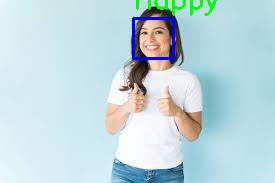

In [1]:
# ✅ Install dependencies
!pip install -q keras opencv-python

# ✅ Download pre-trained emotion model (Mini-XCEPTION, expects 64x64 grayscale)
!wget -q https://github.com/oarriaga/face_classification/raw/master/trained_models/emotion_models/fer2013_mini_XCEPTION.102-0.66.hdf5 -O emotion_model.h5

# ✅ Import everything
import cv2
import numpy as np
from keras.models import load_model
from google.colab import files
from google.colab.patches import cv2_imshow

# ✅ Load model
model = load_model("emotion_model.h5", compile=False)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# ✅ Upload image
uploaded = files.upload()

# ✅ Load face detector
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")

# ✅ Process uploaded image
for filename in uploaded.keys():
    img = cv2.imread(filename)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)

    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (64, 64))  # 🔥 fixed shape
        roi = roi.astype("float32") / 255.0
        roi = np.expand_dims(roi, axis=-1)  # (64, 64, 1)
        roi = np.expand_dims(roi, axis=0)   # (1, 64, 64, 1)

        preds = model.predict(roi, verbose=0)
        label = emotion_labels[np.argmax(preds)]

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # ✅ Show result
    cv2_imshow(img)


In [2]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 38.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 3.6 MB/s eta 0:00:00


In [5]:
import gradio as gr
import cv2
import numpy as np
from keras.models import load_model

# Load face detection and emotion model
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + "haarcascade_frontalface_default.xml")
emotion_model = load_model("emotion_model.h5", compile=False)
emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']

# Prediction function
def detect_emotion(image):
    img = np.array(image)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi = gray[y:y+h, x:x+w]
        roi = cv2.resize(roi, (64, 64))
        roi = roi.astype("float32") / 255.0
        roi = np.expand_dims(roi, axis=-1)
        roi = np.expand_dims(roi, axis=0)

        preds = emotion_model.predict(roi, verbose=0)
        label = emotion_labels[np.argmax(preds)]

        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.putText(img, label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    return img

# Gradio interface
face_interface = gr.Interface(
    fn=detect_emotion,
    inputs=gr.Image(type='pil'),
    outputs=gr.Image(type='numpy'),
    title="Face Emotion Detection",
    description="Upload an image with a face to detect the emotion."
)
face_interface.launch()


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d740320be5296ecec9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [1]:
pip install openai-whisper librosa scikit-learn

In [4]:
import whisper
import librosa
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from moviepy.editor import AudioFileClip

# Step 1: Load Whisper Model for Speech Recognition
model = whisper.load_model("base")

# Step 2: Transcribe Speech using Whisper
def transcribe_audio(audio_path):
    result = model.transcribe(audio_path)
    print("Transcription: ", result["text"])
    return result["text"], result["language"]

# Step 3: Extract Audio Features (MFCCs and Pitch) for Emotion Recognition
def extract_audio_features(audio_path):
    # Load audio using librosa
    y, sr = librosa.load(audio_path, sr=16000)

    # Extract MFCC features
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    # Extract pitch
    pitch, _ = librosa.core.piptrack(y=y, sr=sr)

    # Ensure pitch has same length as MFCC (take mean of pitch over time)
    pitch = np.mean(pitch, axis=1)

    # Calculate mean and standard deviation for MFCCs and pitch as features
    mfcc_features = np.mean(mfcc, axis=1)

    # Limit pitch features to match number of MFCC features (13 features)
    pitch_features = pitch[:13]  # Use first 13 pitch features

    # Combine features
    audio_features = np.concatenate([mfcc_features, pitch_features])

    return audio_features

# Step 4: Train a Simple Emotion Recognition Model (You can train this model beforehand with labeled data)
def train_emotion_classifier():
    # Sample labeled data (features and emotions)
    X = np.random.rand(100, 26)  # 13 MFCC + 13 pitch features
    y = np.random.choice(['happy', 'sad', 'angry', 'neutral'], size=100)

    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)

    # Train a simple classifier (Support Vector Machine)
    classifier = SVC(kernel='linear')
    classifier.fit(X, y_encoded)

    return classifier, le

# Step 5: Classify Emotion Based on Extracted Features
def classify_emotion(features, classifier, le):
    emotion_idx = classifier.predict([features])[0]
    emotion = le.inverse_transform([emotion_idx])[0]
    return emotion

# Step 6: Convert MP4 to WAV using MoviePy
def convert_mp4_to_wav(mp4_path, wav_path):
    audio_clip = AudioFileClip(mp4_path)
    audio_clip.write_audiofile(wav_path, codec='pcm_s16le')

# Step 7: Combine Everything for Emotion-Aware Speech Recognition
def emotion_aware_speech_recognition(mp4_path):
    # Step 7.1: Convert MP4 to WAV
    wav_path = "/content/temp_audio.wav"
    convert_mp4_to_wav(mp4_path, wav_path)

    # Step 7.2: Transcribe Audio
    transcription, language = transcribe_audio(wav_path)

    # Step 7.3: Extract Audio Features for Emotion Detection
    audio_features = extract_audio_features(wav_path)

    # Step 7.4: Classify Emotion Based on Audio Features
    emotion = classify_emotion(audio_features, emotion_classifier, label_encoder)

    # Step 7.5: Output Result
    print(f"Detected Emotion: {emotion}")
    print(f"Transcription: {transcription}")
    print(f"Language Detected: {language}")

# Step 8: Train the Emotion Classifier (Only once)
emotion_classifier, label_encoder = train_emotion_classifier()

# Example usage
audio_path = "sad.m4a"  # Replace with your actual file path
emotion_aware_speech_recognition(audio_path)


MoviePy - Writing audio in /content/temp_audio.wav


  warnings.warn("FP16 is not supported on CPU; using FP32 instead")



MoviePy - Done.
Transcription:   இடிஷ்டியும் காரிவேலையில் மாக்கடு, ஓசமரி செய்துக்கொண்டு இருக்கிறது,
Detected Emotion: angry
Transcription:  இடிஷ்டியும் காரிவேலையில் மாக்கடு, ஓசமரி செய்துக்கொண்டு இருக்கிறது,
Language Detected: ta
